In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

was trying an amazon sagemaker just to get more compute power for training the model. this is left over code from that.

## Loading the data using chunking

In [3]:
# Read JSON file in chunks
chunk_size = 100000  # Adjust the chunk size as needed
chunks = []
with open('Kindle_Store.json', 'r') as file:
    for chunk in pd.read_json(file, chunksize=chunk_size, lines=True):
        chunks.append(chunk)

# Concatenate all chunks to form a single DataFrame
df = pd.concat(chunks, ignore_index=True)

KeyboardInterrupt: 

In [ ]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,True,"12 29, 2012",A27UD5HYAKBL97,1423600150,{'Format:': ' Hardcover'},Cheryl,If you like making salsas this is a great book...,Great Book,1356739200,NaN,NaN
1,5,True,"03 6, 2012",A8P5DK8LLOYGH,1423600150,{'Format:': ' Hardcover'},Shay365,great little book. simple and right to the poi...,great little book,1330992000,3,NaN
2,5,True,"08 12, 2009",A3OM9W7DXSUIIY,1423600150,{'Format:': ' Hardcover'},R. Peckham,This book has good pics of the recipes and eas...,very good bok with good ideas.,1250035200,NaN,NaN
3,3,False,"11 3, 2006",A3DPAR2PWB9BT8,1423600150,{'Format:': ' Hardcover'},JJSS,"I admire the SF School of Cooking, but was dis...",Ok cookbook,1162512000,3,NaN
4,5,False,"04 11, 2006",A2ONTBSAX7GIOV,1423600150,{'Format:': ' Hardcover'},Three Guys from Miami,Many people are surprised to find out that we ...,Fresh and Tasty Ideas from Santa Fe!,1144713600,15,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5722988 entries, 0 to 5722987
Data columns (total 12 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   overall         int64 
 1   verified        bool  
 2   reviewTime      object
 3   reviewerID      object
 4   asin            object
 5   style           object
 6   reviewerName    object
 7   reviewText      object
 8   summary         object
 9   unixReviewTime  int64 
 10  vote            object
 11  image           object
dtypes: bool(1), int64(2), object(9)
memory usage: 485.8+ MB


turn image into dummy

In [ ]:
# if image is non null return 1 else 0
df['image'] = df['image'].notnull().astype('int')

convert votes into int

In [ ]:
# remove commas from vote column
df['vote'] = df['vote'].str.replace(',', '')
# cast vote column to int, converting Nan to 0
df['vote'] = df['vote'].fillna(0)
df['vote'] = df['vote'].astype('int')

replace null with empty string

In [ ]:
# in review text replace null values with empty string
df['reviewText'] = df['reviewText'].fillna('')

convert verfied to dummy

In [ ]:
# convert verified to int 1 if true 0 if false
df['verified'] = df['verified'].astype('int')

checking the types of styles

In [ ]:
df['style'].value_counts()

{'Format:': ' Kindle Edition'}                     5045160
{'Format:': ' Paperback'}                           165154
{'Format:': ' Hardcover'}                            72067
{'Format:': ' Mass Market Paperback'}                10295
{'Format:': ' Audible Audiobook'}                     6455
{'Format:': ' Audio CD'}                              2602
{'Format:': ' Board book'}                            1827
{'Format:': ' Kindle Edition with Audio/Video'}       1429
{'Format:': ' Print Magazine'}                        1116
{'Format:': ' Perfect Paperback'}                      533
{'Format:': ' Leather Bound'}                          463
{'Format:': ' MP3 CD'}                                 419
{'Format:': ' Flexibound'}                             341
{'Format:': ' Comic'}                                  291
{'Format:': ' DVD'}                                    276
{'Format:': ' Spiral-bound'}                           154
{'Format:': ' Library Binding'}                        1

making sure we are only looking at kindle reviews

In [ ]:
# drop row if style is not {'Format:': ' Kindle Edition'} 
df = df[df['style'] == {'Format:': ' Kindle Edition'}]
# drop style column
df = df.drop(columns=['style'])

dropped reviewtime, already have unix representation

In [ ]:
# drop the reviewTime column
df = df.drop(columns='reviewTime')

creating review length column

In [ ]:
# create a new column called reviewLength
df['reviewLength'] = df['reviewText'].str.len()

creating summary length column

In [ ]:
# create a new column called summaryLength
df['summaryLength'] = df['summary'].str.len()

asin is the amazon product id. removing this and the reviewer info

In [ ]:
# removing asin, reviewerID, reviewerName
df = df.drop(columns=['asin', 'reviewerID', 'reviewerName'])

labeling categorical variables

In [ ]:
# labeling ['verified', 'image'] as categorical
df[['verified', 'image']] = df[['verified', 'image']].astype('category')

reviewing data

In [ ]:
df.head()

,overall,verified,reviewText,summary,unixReviewTime,vote,image,reviewLength,summaryLength
9,5,1,For the salsa lover who likes new recipes!!,Five Stars,1418688000,0,0,43,10.0
10,1,1,Recipes are good but the kindle book is just t...,Very bad look in old black and white photocopi...,1414368000,0,0,326,54.0
14,1,1,No color photos. Would not recommend to others...,Not in color as portrayed on Amazon site,1367884800,0,0,130,40.0
15,3,1,"Enjoyed the read. A bit of a twist to it, fun ...",western with a twist.,1412985600,0,0,143,21.0
16,5,1,I have enjoyed all work by this author,Five Stars,1412467200,0,0,38,10.0


reviewing data types

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5045160 entries, 9 to 5722987
Data columns (total 9 columns):
 #   Column          Dtype   
---  ------          -----   
 0   overall         int64   
 1   verified        category
 2   reviewText      object  
 3   summary         object  
 4   unixReviewTime  int64   
 5   vote            int32   
 6   image           category
 7   reviewLength    int64   
 8   summaryLength   float64 
dtypes: category(2), float64(1), int32(1), int64(3), object(2)
memory usage: 298.3+ MB


## Creating BOW

In [ ]:
vectorizer = CountVectorizer(stop_words='english')
reviews = df['reviewText'].tolist()
fitted = vectorizer.fit(reviews)
bow = fitted.transform(reviews)

In [ ]:
bow.shape

(5045160, 648914)

### Lemmatization

lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. Lemmatization is similar to stemming but it brings context to the words. So it links words with similar meaning to one word.

the count vectorizer uses stemming by default, which is a rudimentary heuristic process that chops off the ends of words. this is not ideal for our use case, so we might use lemmatization instead.

In [ ]:
import spacy
import pandas as pd

# Load the SpaCy English model
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def lemmatize_texts(texts):
    docs = list(nlp.pipe(texts, batch_size=100))  # Process texts in batches
    lemmatized_texts = [" ".join([token.lemma_ for token in doc]) for doc in docs]
    return lemmatized_texts

# Apply lemmatization to the 'reviewText' column
df['lemmatized_review'] = lemmatize_texts(df['reviewText'])

KeyboardInterrupt: 

In [ ]:
# Initialize CountVectorizer with lemmatization and stop words removal
vectorizer = CountVectorizer(stop_words='english')
vectorizer.fit(lemmatized_reviews)

In [ ]:
bow = vectorizer.transform(df['lemmatized_reviews'])

In [ ]:
bow.shape

In [ ]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=200)
reduced_bow = tsvd.fit(bow)

KeyboardInterrupt: 

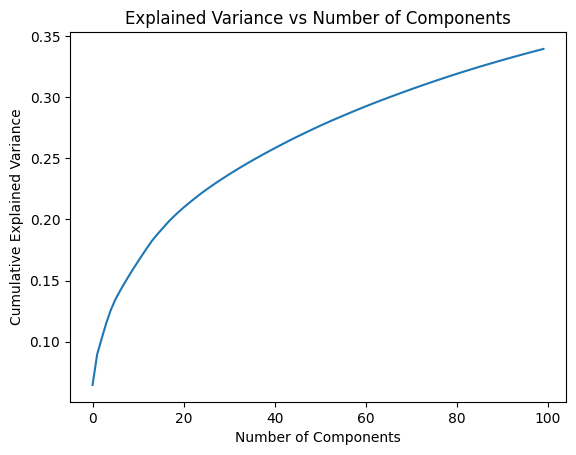

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.cumsum(tsvd.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.show()

in the future could make test_size bigger. figure dataset is so big that it doesn't matter.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Step 1: Prepare the data
X = bow  # Your Bag-of-Words representation
y = df['overall']  # Target variable

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

In [ ]:
# code from a friends notebook that allows for training in batches
# import numpy as np
# import tqdm
# def pred_pairs(alg, test_data):
#     results = []
#     for i in tqdm(range(0, test_data.shape[0], chunk_size)):
#         batch = test_data[i:i+chunk_size]
#         batch_preds = alg.predict(batch)
#         rows, cols = batch.nonzero()
#         batch_labels_nonzero = np.ravel(batch[rows, cols]).tolist()
#         batch_preds_nonzero = np.ravel(batch_preds[rows, cols]).tolist()
#         y_label = batch_labels_nonzero
#         y_pred = batch_preds_nonzero
#         for y_l, y_p in zip(y_label, y_pred):
#             results.append([y_l, y_p])
#     return np.array(results)

In [ ]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler(with_mean=False).fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

to do log regression makes sparse array dense. this is a problem for large datasets.

In [ ]:
# import linear regression
from sklearn.linear_model import LinearRegression
# Step 3: Train a logistic regression model
log_reg = LinearRegression()
log_reg.fit(X_train, y_train)


LinearRegression()

In [ ]:
# Step 4: Evaluate the model
accuracy = log_reg.score(X_test, y_test)
print(f"Accuracy of the linear regression model: {accuracy:.2f}")

Accuracy of the linear regression model: 0.16
